<a href="https://colab.research.google.com/github/Haebuk/sparta_ML/blob/main/4%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5_01_Sign_Language_MNIST_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝에서 실행 속도를 더 빠르게 하는 방법

지금까지는 CPU를 사용했는데 GPU를 사용하면 딥러닝의 연산속도를 대폭 향상시킬 수 있습니다!

[런타임] - [런타임 유형 변경] - 하드웨어 가속기 GPU 선택 저장

# 데이터셋 다운로드

영어 알파벳 수화 데이터셋

https://www.kaggle.com/datamunge/sign-language-mnist

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'haebuk' # username
os.environ['KAGGLE_KEY'] = '6c964b083d7917c00cc846d7c4b939cf' # key

In [2]:
!kaggle datasets download -d datamunge/sign-language-mnist

 78% 49.0M/62.6M [00:01<00:00, 23.7MB/s]
100% 62.6M/62.6M [00:01<00:00, 46.3MB/s]


In [3]:
!unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


# 패키지 로드

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 데이터 증강
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 데이터셋 로드

In [5]:
train_df = pd.read_csv('sign_mnist_train.csv')

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [6]:
test_df = pd.read_csv('sign_mnist_test.csv')

test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


# 라벨 분포
- 9=J or 25=Z 는 동작이 들어가므로 제외
- 총 24개의 라벨

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


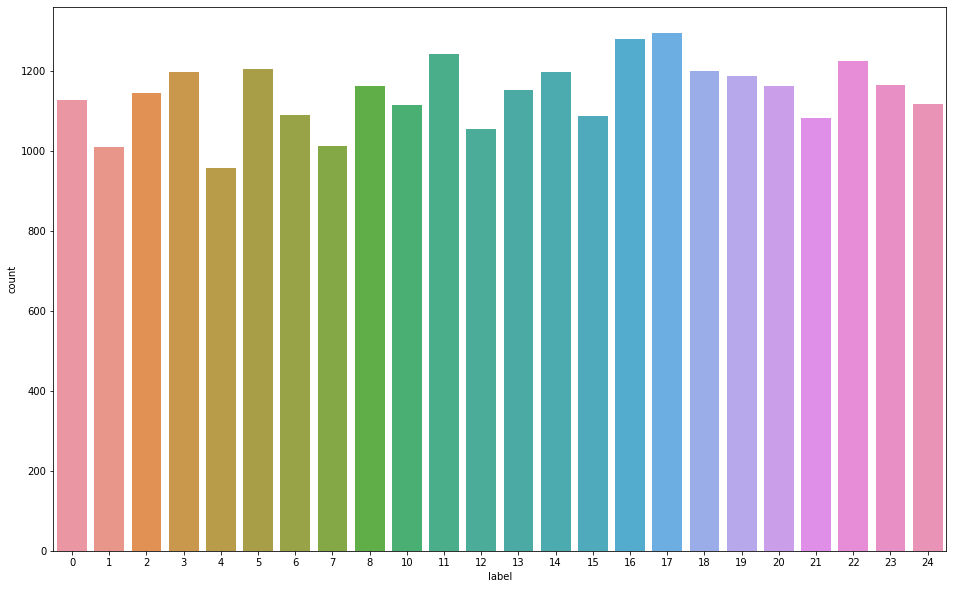

In [7]:
plt.figure(figsize=(16, 10))
sns.countplot(train_df['label'])
plt.show()

# 전처리

## 입력과 출력 나누기

- x 데이터를 (28, 28, 1) 크기의 이미지 형태로 변환합니다!

In [8]:
train_df = train_df.astype(np.float32) # 무조건
x_train = train_df.drop(columns=['label'], axis=1).values
x_train = x_train.reshape((-1, 28, 28, 1)) # -1: 데이터셋 크기, 28*28: 사이즈, 1: gray 
y_train = train_df[['label']].values

test_df = test_df.astype(np.float32)
x_test = test_df.drop(columns=['label'], axis=1).values
x_test = x_test.reshape((-1, 28, 28, 1))
y_test = test_df[['label']].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(27455, 28, 28, 1) (27455, 1)
(7172, 28, 28, 1) (7172, 1)


## 데이터 미리보기

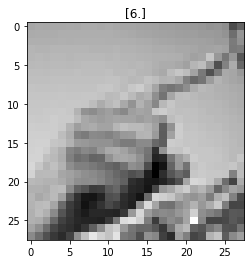

In [9]:
index = 1
plt.title(str(y_train[index]))
plt.imshow(x_train[index].reshape((28, 28)), cmap='gray')
plt.show()

## One-hot encoding

In [10]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
y_test = encoder.fit_transform(y_test).toarray()

print(y_train.shape)

(27455, 24)


## 일반화

이미지 데이터는 픽셀이 0-255 사이의 정수(unsigned integer 8bit = uint8)로 되어 있습니다. 이것을 255로 나누어 0-1 사이의 소수점 데이터(floating point 32bit = float32)로 바꾸고 일반화 시키도록 할게요!

이번에는 ImageDataGenerator()를 사용해서 일반화 시켜보겠습니다!

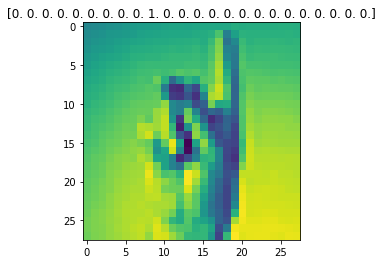

In [11]:
train_image_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
)

# 데이터 배치 단위로 나누기
train_datagen = train_image_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=256,
    shuffle=True # 섞는게 약간의 성능 향상에 도움이 된다고 함
)

test_image_datagen = ImageDataGenerator(
  rescale=1./255
)

test_datagen = test_image_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=256,
    shuffle=False # 안 섞음
)

index = 1

# 미리보기
preview_img = train_datagen.__getitem__(0)[0][index]
preview_label = train_datagen.__getitem__(0)[1][index]

plt.imshow(preview_img.reshape((28, 28)))
plt.title(str(preview_label))
plt.show()

# 네트워크 구성

In [12]:
input = Input(shape=(28, 28, 1))

# 필터 개수는 튜닝 파라미터
hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden) # 반으로 줄임

hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Flatten()(hidden) # 일차원으로 펼치기

hidden = Dense(512, activation='relu')(hidden)

hidden = Dropout(rate=0.3)(hidden) # 과적합 방지 30% 노드 제외

output = Dense(24, activation='softmax')(hidden)

model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# 학습

In [13]:
history = model.fit(
    train_datagen,
    validation_data=test_datagen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20 # epochs 복수형으로 쓰기!
)

Epoch 1/20
108/108 [==============================] - 17s 14ms/step - loss: 2.1629 - acc: 0.3493 - val_loss: 1.0056 - val_acc: 0.6846
Epoch 2/20
108/108 [==============================] - 1s 11ms/step - loss: 0.5728 - acc: 0.8127 - val_loss: 0.4757 - val_acc: 0.8514
Epoch 3/20
108/108 [==============================] - 1s 12ms/step - loss: 0.1862 - acc: 0.9434 - val_loss: 0.2761 - val_acc: 0.9045
Epoch 4/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0749 - acc: 0.9802 - val_loss: 0.2390 - val_acc: 0.9176
Epoch 5/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0347 - acc: 0.9925 - val_loss: 0.2149 - val_acc: 0.9357
Epoch 6/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0242 - acc: 0.9945 - val_loss: 0.2299 - val_acc: 0.9342
Epoch 7/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0163 - acc: 0.9964 - val_loss: 0.1937 - val_acc: 0.9417
Epoch 8/20
108/108 [==============================] - 1s 12ms/step -

# 학습 결과 그래프

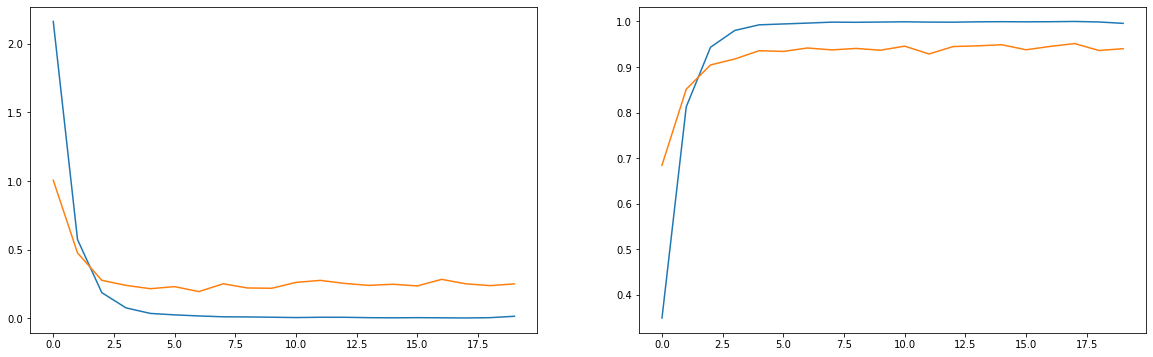

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# 이미지 증강 기법

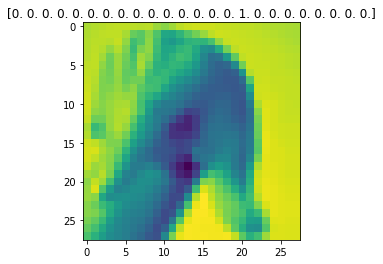

In [16]:
train_image_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10,  # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
)

train_datagen = train_image_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=256,
    shuffle=True
)

test_image_datagen = ImageDataGenerator(
  rescale=1./255
)

test_datagen = test_image_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=256,
    shuffle=False
)

index = 1

preview_img = train_datagen.__getitem__(0)[0][index]
preview_label = train_datagen.__getitem__(0)[1][index]

plt.imshow(preview_img.reshape((28, 28)))
plt.title(str(preview_label))
plt.show()

In [17]:
input = Input(shape=(28, 28, 1))

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Flatten()(hidden)

hidden = Dense(512, activation='relu')(hidden)

hidden = Dropout(rate=0.3)(hidden)

output = Dense(24, activation='softmax')(hidden)

model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
history = model.fit(
    train_datagen,
    validation_data=test_datagen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20 # epochs 복수형으로 쓰기!
)

Epoch 1/20
108/108 [==============================] - 8s 74ms/step - loss: 2.6517 - acc: 0.2063 - val_loss: 1.4993 - val_acc: 0.5715
Epoch 2/20
108/108 [==============================] - 8s 72ms/step - loss: 1.2957 - acc: 0.5881 - val_loss: 0.6700 - val_acc: 0.7598
Epoch 3/20
108/108 [==============================] - 8s 72ms/step - loss: 0.7560 - acc: 0.7490 - val_loss: 0.3883 - val_acc: 0.8744
Epoch 4/20
108/108 [==============================] - 8s 73ms/step - loss: 0.5019 - acc: 0.8337 - val_loss: 0.2305 - val_acc: 0.9414
Epoch 5/20
108/108 [==============================] - 8s 74ms/step - loss: 0.3757 - acc: 0.8724 - val_loss: 0.1719 - val_acc: 0.9508
Epoch 6/20
108/108 [==============================] - 8s 73ms/step - loss: 0.2819 - acc: 0.9070 - val_loss: 0.1648 - val_acc: 0.9487
Epoch 7/20
108/108 [==============================] - 8s 73ms/step - loss: 0.2202 - acc: 0.9285 - val_loss: 0.1135 - val_acc: 0.9611
Epoch 8/20
108/108 [==============================] - 8s 73ms/step - 

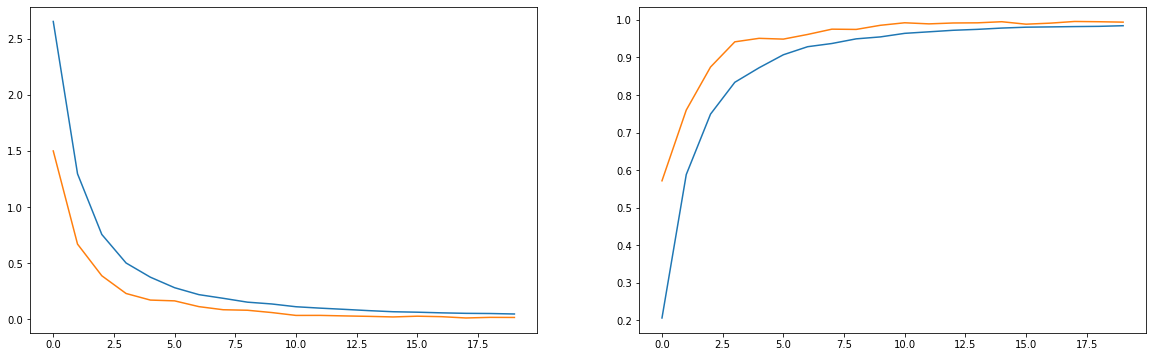

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])